In [15]:
import torch
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%env CUDA_VISIBLE_DEVICES=0
torch.cuda.set_device(0)
device = 'cuda:0'
sys.path.append('../')
from vq_gan_3d.model.vqgan import VQGAN
from train.get_dataset import get_dataset
import matplotlib.pyplot as plt
import SimpleITK as sitk
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

env: CUDA_VISIBLE_DEVICES=0


In [34]:
# LIDC
DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/LIDC/model-78.pt'
#VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/LIDC/lightning_logs/version_0/checkpoints/epoch\=100-step\=102000-train/recon_loss\=0.33.ckpt'
VQGAN_CHECKPOINT = "/home/ge.polymtl.ca/p120530/Training/medif/checkpoints/0905_e620_rc_0.09.ckpt"

with initialize(config_path="../config/"):
		cfg=compose(config_name="base_cfg.yaml", overrides=[
			"model=ddpm",
			 "dataset=default",
			 "dataset.root_dir=/home/ge.polymtl.ca/p120530/Training/medif/preprocessed_3D_images",
			 f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
			 "model.diffusion_img_size=16",
			 "model.diffusion_depth_size=16",
			 "model.diffusion_num_channels=8",
			 "model.dim_mults=[1,2,4,8]",
			 "model.batch_size=40 ",
			 "model.gpus=0 ",
			])

#vqgan = VQGAN.load_from_checkpoint('/data/home/firas/Desktop/work/other_groups/vq_gan_3d/checkpoints_generation/knee_mri_gen/lightning_logs/version_0/checkpoints/epoch=228-step=207000-train/recon_loss=0.91.ckpt', map_location=device)
vqgan = VQGAN.load_from_checkpoint(VQGAN_CHECKPOINT)
vqgan = vqgan.to(device)
vqgan.eval()

/tmp/ipykernel_740722/4224451017.py:6: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../config/"):
/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from /home/ge.polymtl.ca/p120530/Training/medif/vq_gan_3d/model/cache/vgg.pth


VQGAN(
  (encoder): Encoder(
    (conv_blocks): ModuleList(
      (0): Module(
        (down): SamePadConv3d(
          (conv): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
        (res): ResBlock(
          (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv1): SamePadConv3d(
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv2): SamePadConv3d(
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
          )
        )
      )
    )
    (conv_first): SamePadConv3d(
      (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    )
    (final_block): Sequential(
      (0): GroupNorm(32, 32, eps=1e-06, affine=True)
      (1): SiLU()
    )
  )
  (decoder): Decoder(
    (final_block): Sequential(
      (0): GroupNorm(32, 32, eps=1e-06, affine=True)
      (1): SiL

In [35]:
#task = 'acl'
#plane = 'sagittal'
#root_dir = '/data/home/firas/Desktop/work/MR_Knie/Data/MRNet/MRNet-v1.0/'
#val_dataset = MRNetDataset(root_dir=root_dir, task=task, plane=plane, split='valid')
#sample = val_dataset[0]

#val_dataset = BRATSDataset(root_dir='/data/BraTS/BraTS 2020', train=False, imgtype='flair')
#sample = val_dataset[3]
print(cfg.dataset.name)
val_dataset = get_dataset(cfg)
sample = val_dataset[0][0]
print(sample['data'].shape)

DEFAULT
Found 208 files in /home/ge.polymtl.ca/p120530/Training/medif/preprocessed_3D_images
Found 208 files in /home/ge.polymtl.ca/p120530/Training/medif/preprocessed_3D_images
torch.Size([1, 16, 256, 256])


In [18]:
input_ = torch.tensor(sample['data'][None]).to(device)

/tmp/ipykernel_740722/3842533679.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(sample['data'][None]).to(device)


In [36]:
with torch.no_grad():
	output_ = vqgan(input_)

print(output_[1].shape)
# convert to numpy
output_np = output_[1][0][0].cpu().numpy()
input_np = input_[0][0].cpu().numpy()

print(output_np.shape)
print(input_np.shape)

torch.Size([1, 1, 16, 256, 256])
(16, 256, 256)
(16, 256, 256)


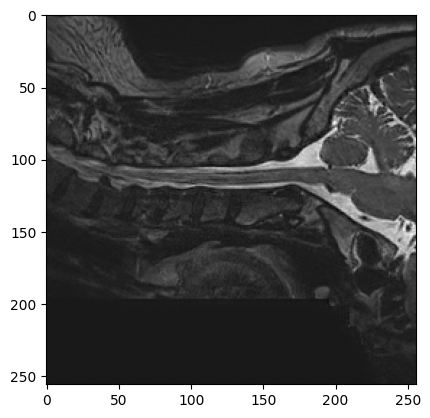

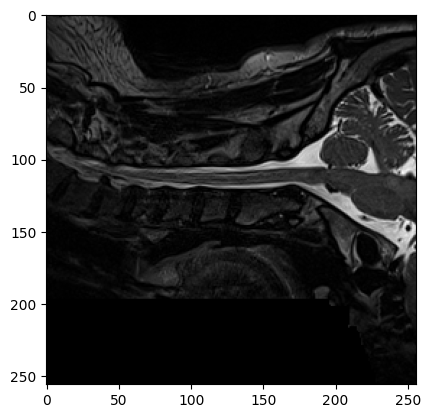

In [37]:
IDX = 8
plt.imshow(output_np[IDX,:,:], cmap='gray')
plt.show()
plt.imshow(input_np[IDX,:,:], cmap='gray')
plt.show()

In [23]:
sitk.WriteImage(sitk.GetImageFromArray(output_[1][0][0].cpu()), 'outputs/.nii')
sitk.WriteImage(sitk.GetImageFromArray(input_[0][0].cpu()), '/data/home/firas/Desktop/work/other_groups/vq_gan_3d/evaluation/input.nii')